TEXT CLUSTERING FOR CUSTOMER COMMENTS

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

In [2]:
# Setup
nltk.download('stopwords')
nltk.download('wordnet')

# Load the data
df = pd.read_csv("customer_comments_with_dates.csv")

# Convert comment_date column to datetime type
df["comment_date"] = pd.to_datetime(df["comment_date"])

# Keep only comments within the first 2 weeks after release
start_date = "2025-06-15"
end_date = "2025-06-30"
df = df[(df["comment_date"] >= start_date) & (df["comment_date"] <= end_date)]

# Remove empty comments
df = df.dropna(subset=["comment"])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\panty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\panty\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df

,review_id,region,device,comment,comment_date
0,1,EU,Android,"Every time I add something, it just vanishes f...",2025-06-16 21:25:51
1,2,EU,Android,"Checkout button randomly disappears, can't com...",2025-06-22 10:38:01
2,3,US,Android,This new design made ordering so inconvenient,2025-06-16 16:29:17
3,4,EU,Android,"Super confusing checkout flow, lost patience h...",2025-06-20 06:02:02
4,5,ASIA,iOS,"Easy to find what I need, filters work great",2025-06-21 11:19:24
...,...,...,...,...,...
95,96,EU,Android,Not sure what happened but placing an order is...,2025-06-20 16:50:50
96,97,US,iOS,Filters work really good,2025-06-23 07:21:07
97,98,EU,Android,Super confusing checkout,2025-06-19 09:56:45
98,99,EU,Android,"The cart became so inconvenient, takes forever...",2025-06-18 12:13:33


In [4]:
# Text cleaning and preprocessing
stop_words = set(stopwords.words('english'))  
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z]", " ", text)  # keep only letters
    words = text.split()
    words = [w for w in words if w not in stop_words] # remove stopwords
    words = [lemmatizer.lemmatize(w) for w in words] # lemmatization
    return " ".join(words)

df["clean_text"] = df["comment"].apply(clean_text)

In [5]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features = 5000)
X = vectorizer.fit_transform(df["clean_text"])

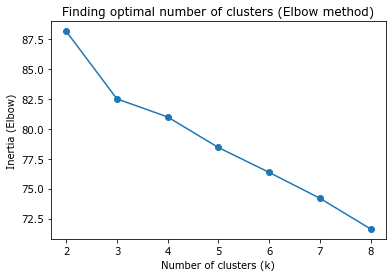

In [6]:
# Find the optimal number of clusters (Elbow method)
inertia = []
K_range = range(2, 9)
for k in K_range:
    km = KMeans(n_clusters = k, random_state = 42)
    km.fit(X)
    inertia.append(km.inertia_)

plt.plot(K_range, inertia, marker = "o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Elbow)")
plt.title("Finding optimal number of clusters (Elbow method)")
plt.show()

The Elbow method curve shows a sharp drop in inertia between k=2 and k=3, after which the decrease becomes much more gradual. This indicates that the main structure in the data is captured with 3 clusters. So k = 3 is selected as the optimal number of clusters for this analysis

In [7]:
# Final clustering
kmeans = KMeans(n_clusters = 3, random_state = 42)
df["cluster"] = kmeans.fit_predict(X)

In [8]:
# Cluster quality evaluation
score = silhouette_score(X, df["cluster"])
print(f"Silhouette score: {score:.3f}")

Silhouette score: 0.063


In [9]:
# Show top terms and sample comments per cluster
terms = vectorizer.get_feature_names_out()
for i in range(3):
    cluster_terms = kmeans.cluster_centers_[i].argsort()[-10:][::-1]
    top_terms = [terms[ind] for ind in cluster_terms]
    print(f"\nCluster {i}: {' | '.join(top_terms)}")
    sample = df[df.cluster == i]["comment"].head(3).to_list()
    print("Example comments:")
    for s in sample:
        print("   -", s)


Cluster 0: checkout | order | design | super | smooth | new | feel | confusing | product | love
Example comments:
   - Checkout button randomly disappears, can't complete my order
   - This new design made ordering so inconvenient
   - Super confusing checkout flow, lost patience halfway

Cluster 1: customer | refund | quickly | got | helpful | support | top | notch | service | solved
Example comments:
   - Got my refund quickly, customer support was helpful
   - Got my refund quickly, customer support was helpful
   - Customer service is top-notch, solved my issue fast

Cluster 2: cart | became | shopping | inconvenient | update | add | see | item | ui | anymore
Example comments:
   - Every time I add something, it just vanishes from the cart
   - After the update, I stopped buying because the cart is broken
   - After the update, the cart became inconvenient and slow
